In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import shap
import warnings
import random
from tqdm import tqdm
from itertools import combinations
from scipy.sparse import coo_matrix
warnings.filterwarnings('ignore')

RESOLUTION = 25
window_size = 401

assays = ['DNase', 'H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K9me3']

In [2]:
colnames = ["pos_" + str(x) for x in list(range(-(window_size//2), (window_size//2) + 1))]
colnames = colnames + ["log10p1(TPM)", "cell_type", "chrom", "position", "strand", "assay_index"] 
df = pd.read_csv('../Data/Normalized.Training_Data.csv', sep=",", names=colnames, low_memory=False)
df

,pos_-200,pos_-199,pos_-198,pos_-197,pos_-196,pos_-195,pos_-194,pos_-193,pos_-192,pos_-191,...,pos_197,pos_198,pos_199,pos_200,log10p1(TPM),cell_type,chrom,position,strand,assay_index
0,0.305523,0.305523,0.305523,0.305523,0.305523,0.305523,0.305523,0.305523,0.305523,0.305523,...,0.305523,0.305523,0.305523,0.305523,0.0,T01,chr1,27466,-,1
1,0.404711,0.404711,0.404711,0.404711,0.404711,0.404711,0.404711,0.404711,0.404711,0.404711,...,0.404711,0.404711,0.404711,0.404711,0.0,T01,chr1,27466,-,2
2,0.352197,0.352197,0.352197,0.352197,0.352197,0.352197,0.352197,0.352197,0.352197,0.352197,...,0.352197,0.352197,0.352197,0.352197,0.0,T01,chr1,27466,-,3
3,0.345510,0.345510,0.345510,0.345510,0.345510,0.345510,0.345510,0.345510,0.345510,0.345510,...,0.345510,0.345510,0.345510,0.345510,0.0,T01,chr1,27466,-,4
4,0.342030,0.342030,0.342030,0.342030,0.342030,0.342030,0.342030,0.342030,0.342030,0.342030,...,0.342030,0.342030,0.342030,0.342030,0.0,T01,chr1,27466,-,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935468,0.357446,0.412326,0.407789,0.398536,0.404581,0.324968,0.313034,0.313752,0.338428,0.356020,...,0.347971,0.348321,0.322026,0.332254,0.0,T13,chr22,2019474,+,3
935469,0.802335,1.133210,1.049832,1.049832,1.124592,1.226962,1.226962,1.442706,1.463740,1.378121,...,0.316077,0.316077,0.316077,0.316077,0.0,T13,chr22,2019474,+,4
935470,0.437168,0.358530,0.379583,0.379583,0.379583,0.379583,0.364877,0.437965,0.630581,0.567302,...,0.604903,0.509733,0.451201,0.489364,0.0,T13,chr22,2019474,+,5
935471,0.756888,0.813601,1.089862,1.102051,1.104208,1.061381,1.016406,0.747131,0.631313,0.512288,...,0.381220,0.381220,0.413746,0.453687,0.0,T13,chr22,2019474,+,6


100%|██████████| 10000/10000 [00:19<00:00, 507.23it/s]


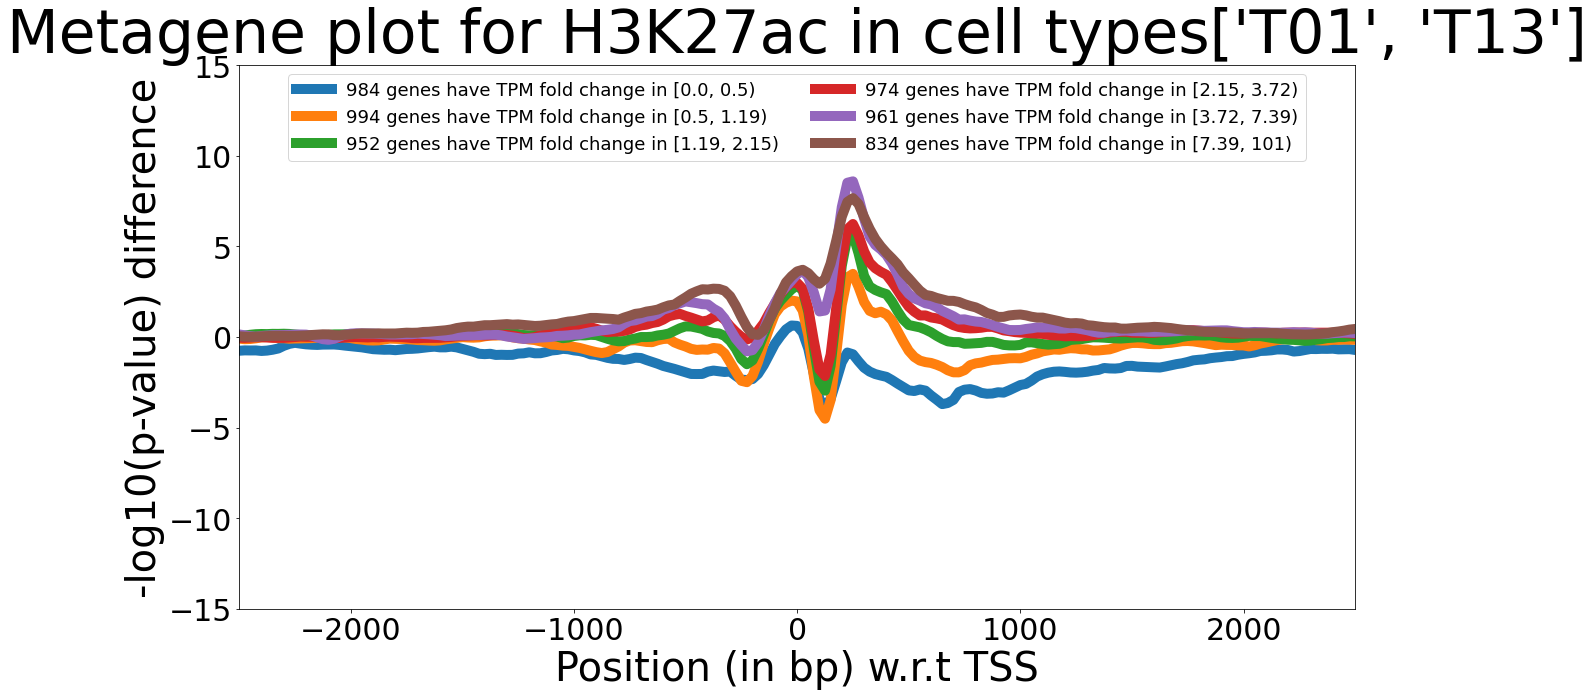

100%|██████████| 10000/10000 [00:19<00:00, 502.23it/s]


Train: MSE =  0.087 Pearson = 0.793 Spearman = 0.789
Test: MSE =  0.777 Pearson = 0.139 Spearman = 0.319


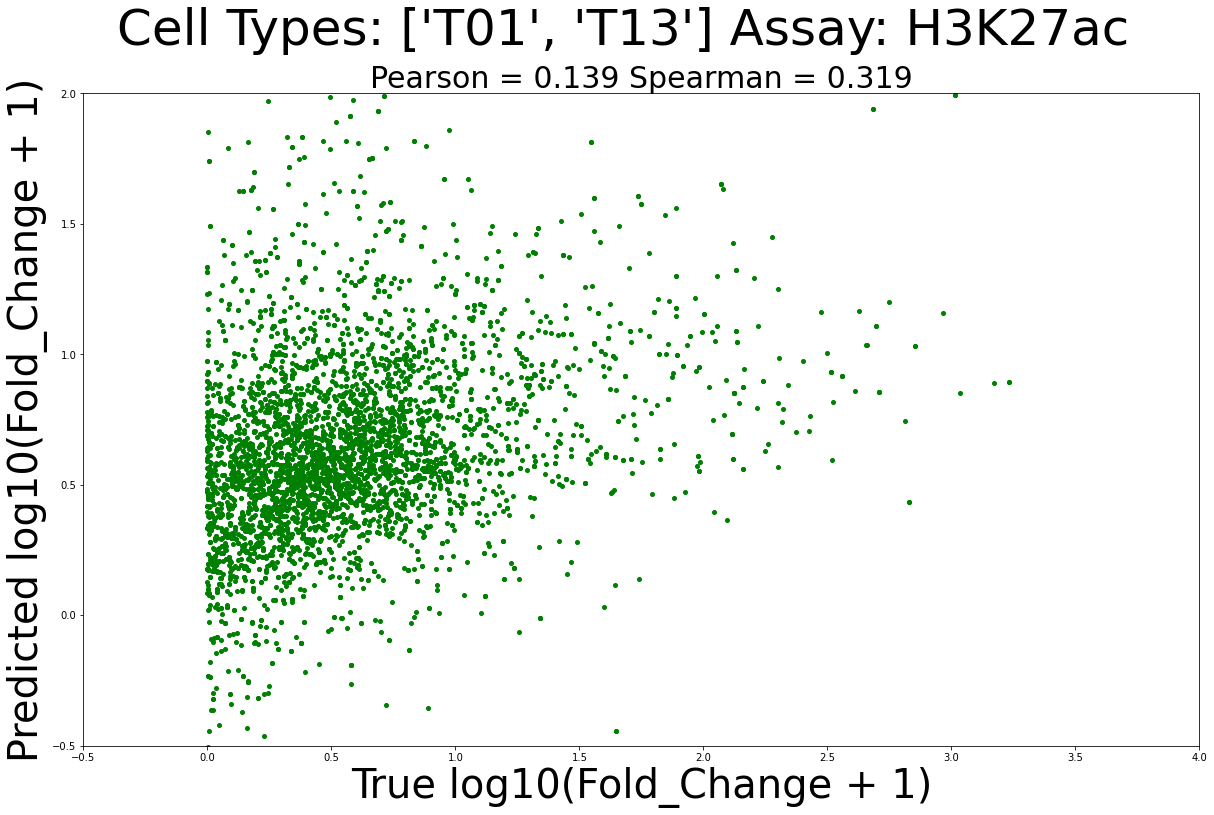

100%|██████████| 10000/10000 [00:19<00:00, 504.47it/s]


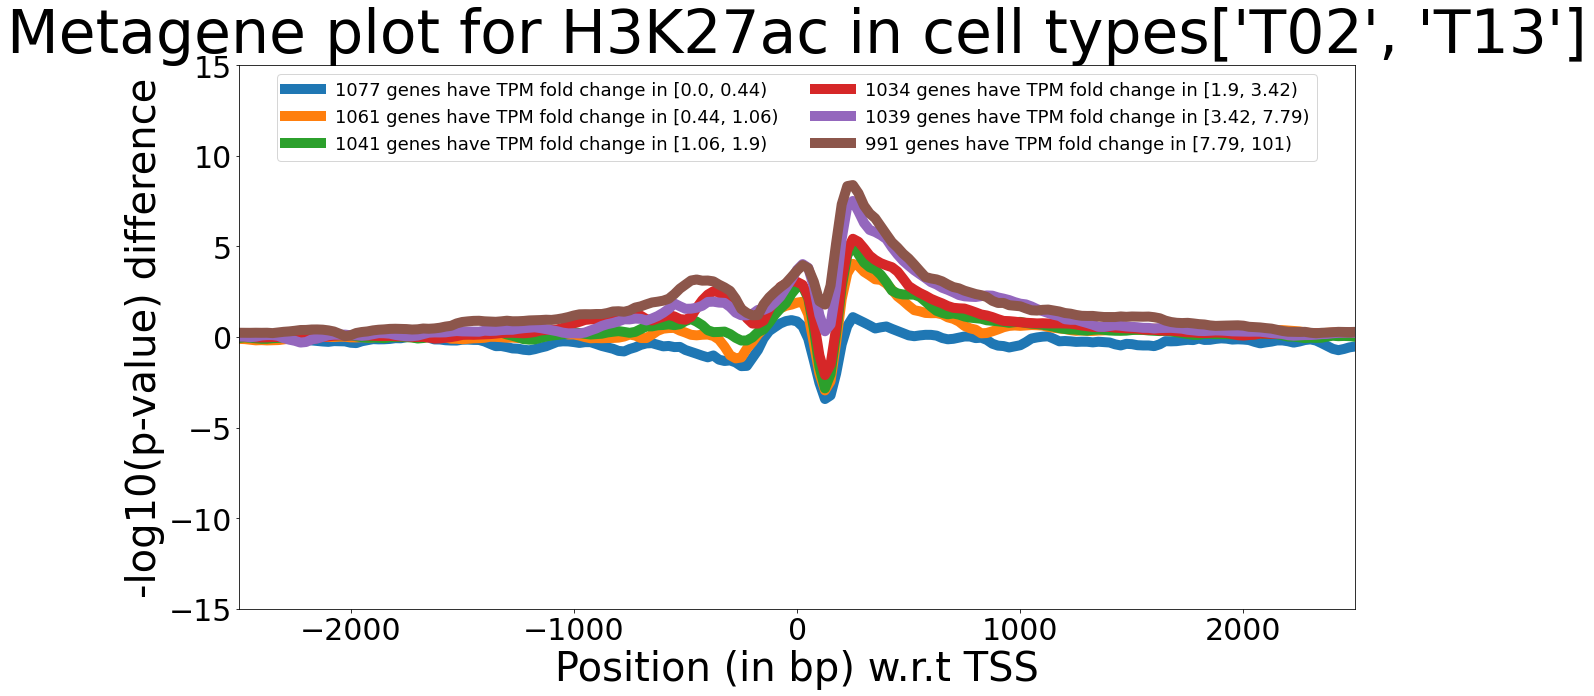

100%|██████████| 10000/10000 [00:21<00:00, 468.44it/s]


Train: MSE =  0.066 Pearson = 0.778 Spearman = 0.787
Test: MSE =  0.331 Pearson = 0.16 Spearman = 0.226


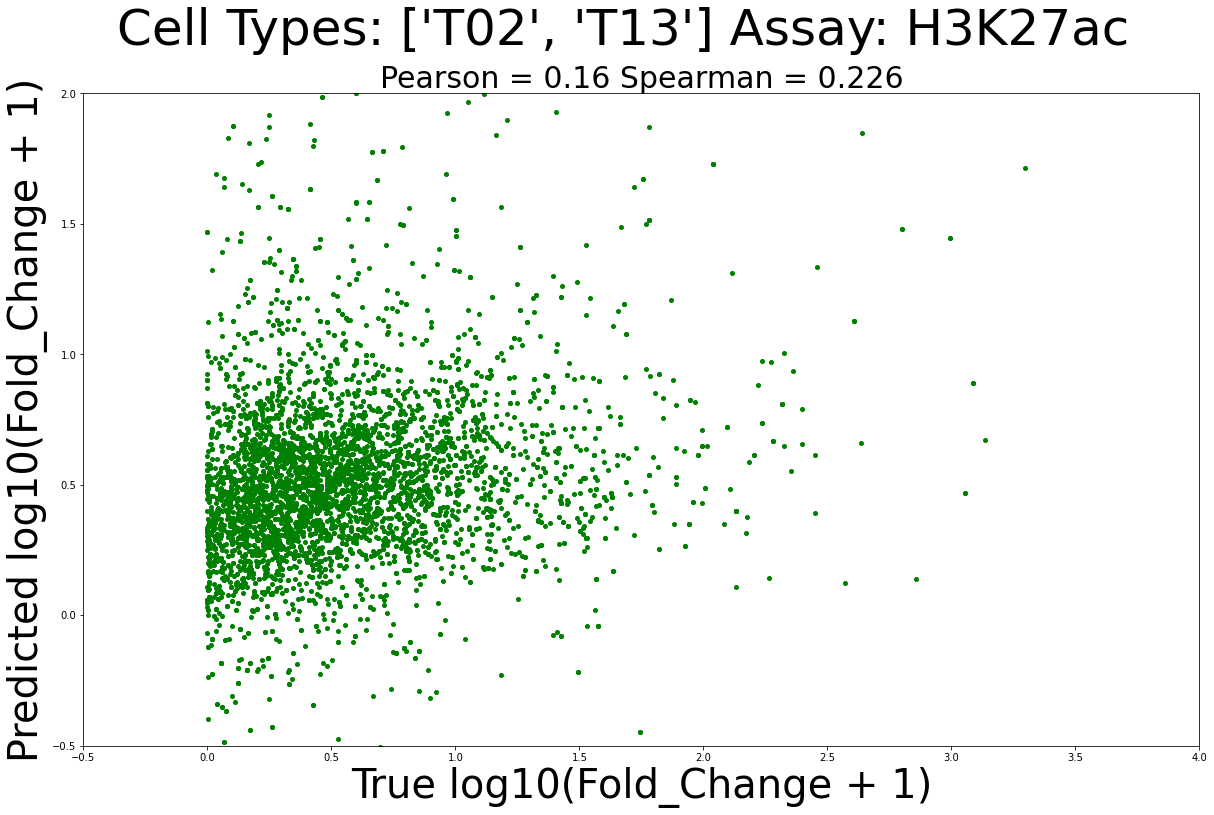

100%|██████████| 10000/10000 [00:19<00:00, 514.03it/s]


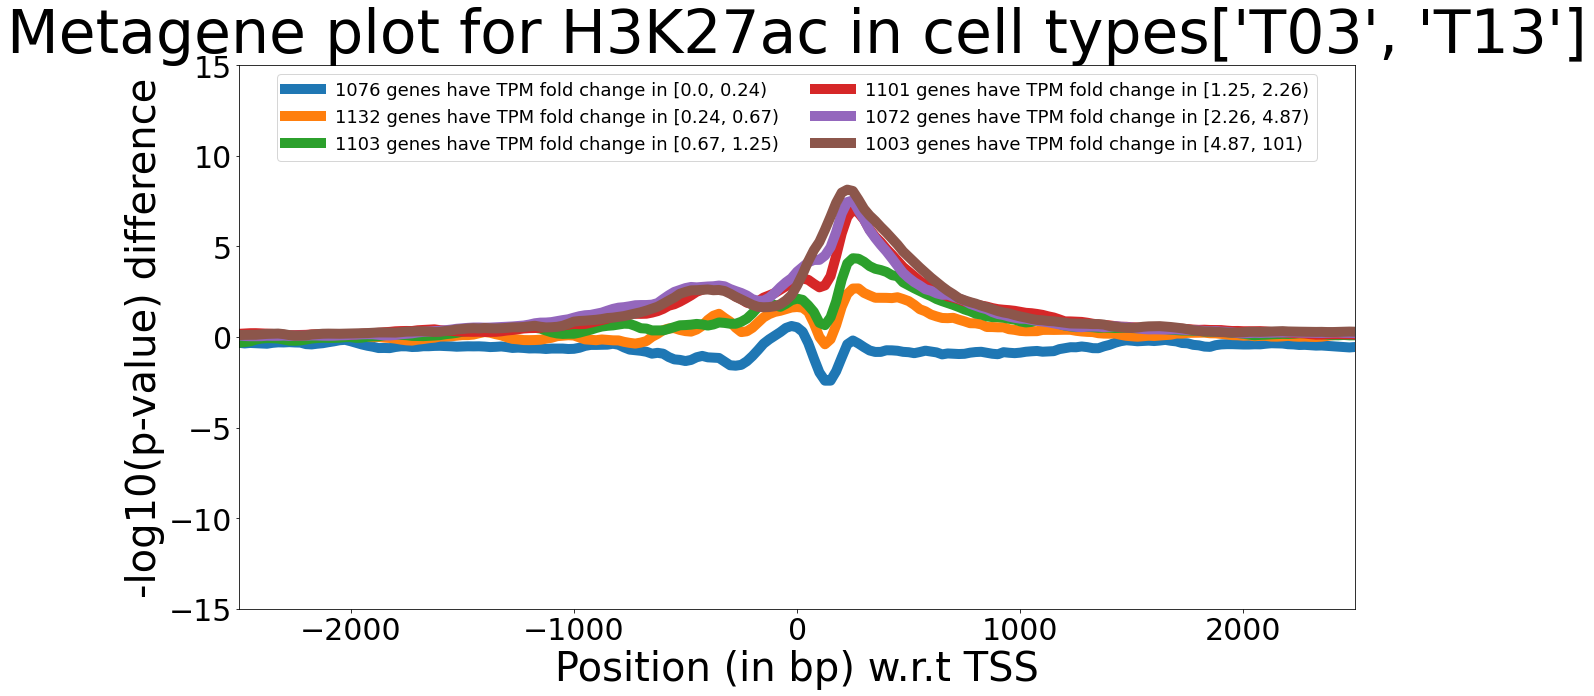

100%|██████████| 10000/10000 [00:20<00:00, 479.86it/s]


Train: MSE =  0.142 Pearson = 0.53 Spearman = 0.646
Test: MSE =  0.463 Pearson = 0.121 Spearman = 0.275


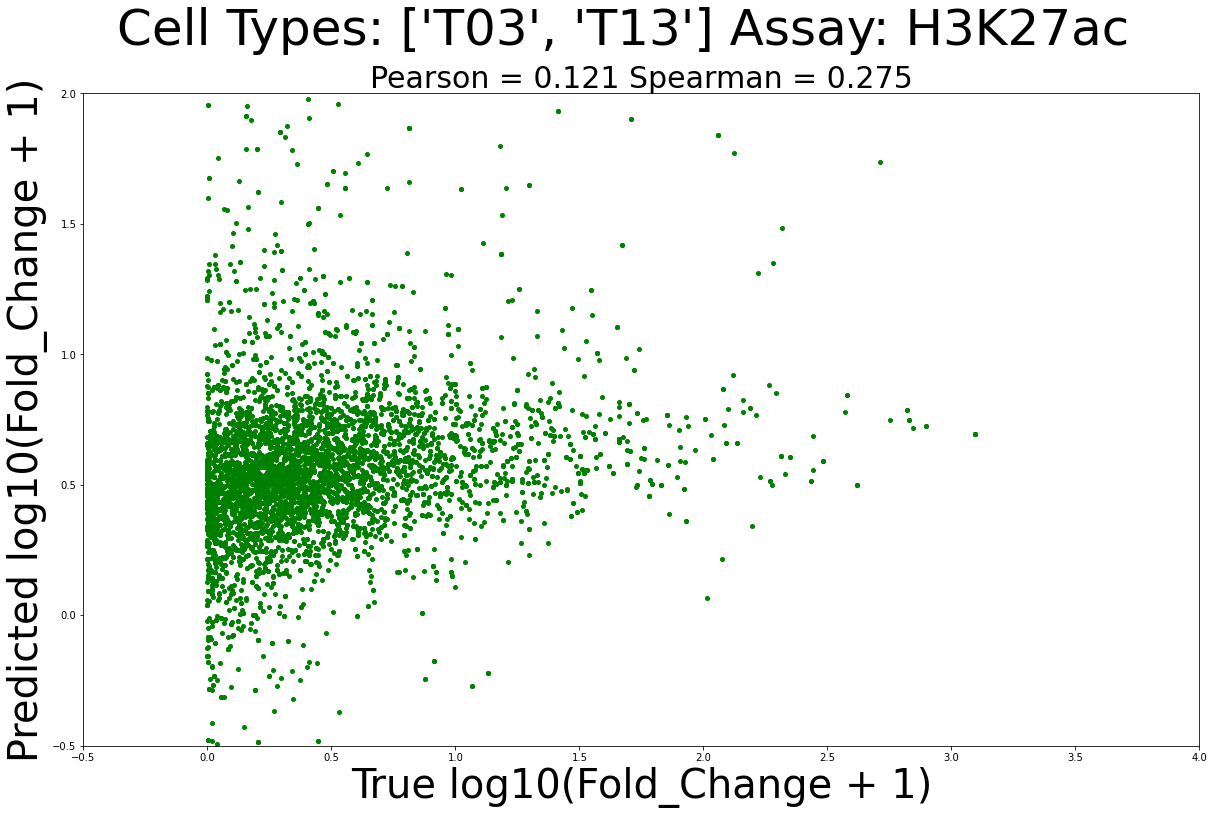

 48%|████▊     | 4800/10000 [00:09<00:09, 520.05it/s]


KeyboardInterrupt: 

In [5]:
# Metagene plots
for assay_index in range(4, 5):

    results = []

    # cell_type_pairs = list(combinations(["T{0:0=2d}".format(x) for x in range(1, 13)], 2))
    # cell_type_pairs = [["T05", "T13"]]
    cell_type_pairs = [[x, "T13"] for x in ["T{0:0=2d}".format(x) for x in range(1, 13)]]

    for cell_types in cell_type_pairs:
#     cell_types = random.sample(cell_type_pairs, 1)[0]

        df_assay = df[(df["assay_index"] == assay_index) & ((df["cell_type"] == cell_types[0]) | (df["cell_type"] == cell_types[1]))]
        df_pairs = df_assay[["cell_type", "chrom", "position", "strand"]]
        df_pairs_sorted = df_pairs.sort_values(['chrom', 'position', 'strand', 'cell_type'], ascending=[1, 1, 1, 1])
        df_pairs_2 = df_pairs_sorted.drop_duplicates()
        df_pairs_2["row_numbers"] = df_pairs_2.index
        df_pairs_3 = df_pairs_2.groupby(["chrom", "position", "strand"])['row_numbers'].apply(list)
        df_pairs_3 = list(df_pairs_3)

        # Now to generate a dataset, randomly sample an element from df_pairs_3, then sample two elements from it
        df_pairs_dataset = []
        df_x1 = []
        df_x2 = []
        for i in tqdm(range(10000)):
            random_list = random.sample(df_pairs_3, 1)[0]
            if(len(random_list) > 1):
                row_index_1, row_index_2 = random.sample(random_list, 2)
            else:
                # this gene has only one cell type's data extracted from the keras generator, for now
                continue

            cell_type_1 = df.iloc[row_index_1, -5]
            cell_type_2 = df.iloc[row_index_2, -5]

            if(cell_type_2 == "T13"):
                temp_row_index = row_index_1
                row_index_1 = row_index_2
                row_index_2 = temp_row_index

            cell_type_1 = df.iloc[row_index_1, -5]
            cell_type_2 = df.iloc[row_index_2, -5]

            assert(cell_type_1 == "T13")
            assert(cell_type_2 != "T13")     

            # The row numbers are from df not df_assay    
            x_row_1 = np.expm1(list(df.iloc[row_index_1, :window_size]))
            x_row_2 = np.expm1(list(df.iloc[row_index_2, :window_size]))

            y_row_1 = df.iloc[row_index_1, window_size] 
            y_row_2 = df.iloc[row_index_2, window_size]

            x = x_row_1 - x_row_2 # This subtraction is in the -log10(p-values) space

            if(y_row_1 == 0):
                y = 0
                # This adds too much noise to the dataset
                continue
            elif(y_row_2 == 0):
                y = 100000 # Some arbitrary large value
                # For now we will ignore these also
                continue
            else:
                y = (np.power(10, y_row_1)-1) / (np.power(10, y_row_2)-1)

            df_pairs_dataset.append((x, y))

        data_x = [x[0] for x in df_pairs_dataset]
        data_y = [y[1] for y in df_pairs_dataset]
        column_names = ["pos_" + str(x) + "_" + assays[assay_index-1] for x in list(range(-(window_size//2), (window_size//2) + 1))]
        df_pairs_analysis = pd.DataFrame(data_x, columns = column_names)
        df_pairs_analysis["TPM_fold_change"] = data_y
        # df_pairs_analysis.to_csv("df_pairs_analysis."+assays[assay_index-1]+".tsv", sep="\t")

        # Create sausage plots of different assays by gene expression quantiles
        # df_pairs_analysis = pd.read_csv("df_pairs_analysis."+assays[assay_index-1]+".tsv", sep="\t")

        plt.rcParams["figure.figsize"] = (20, 10)
        xticklabels = [RESOLUTION*x for x in range(-(window_size//2), (window_size//2)+1)]

        # Step-1: Define gene expression quantiles
        # sns.histplot(list(df_pairs_analysis["TPM_fold_change"]), bins=100, cumulative=True, stat="probability")
        # plt.show()
        # plt.close()

        # quantiles = [-0.01, 0.001, 0.02, 0.097, 0.255, 0.477, 0.699, 1.0415, 1000.0]
        number_of_quantiles = 6 # len(quantiles)
        quantiles = [df_pairs_analysis["TPM_fold_change"].drop_duplicates().quantile(x) for x in np.arange(0, 1, 1.0/(number_of_quantiles*1.0))] + [101]

        # # Step-2: Group features by their quantile
        # # Number of genes for H3K27ac in T01 for all 20 quantiles
        df_pairs_quantiles = {}
        for i in range(1, number_of_quantiles+1):
            df_pairs_quantiles[i] = df_pairs_analysis[(df_pairs_analysis["TPM_fold_change"] >= quantiles[i-1]) & (df_pairs_analysis["TPM_fold_change"] < quantiles[i])]

            # Step-3: Create sausage plot for each quantile within df_quantile
            y_means = df_pairs_quantiles[i].iloc[:, :window_size].mean()
            y_stds = df_pairs_quantiles[i].iloc[:, :window_size].std()

            plt.plot(xticklabels, y_means, 
                     label=str(df_pairs_quantiles[i].shape[0])+
                           " genes have TPM fold change in ["+
                           str(round(quantiles[i-1], 2))+
                           ", "+
                           str(round(quantiles[i], 2))+
                           ")",
                           linewidth=10)
        #     plt.fill_between(xticklabels,
        # #                     range(-(window_size//2), (window_size//2)+1),
        #                      df_pairs_quantiles[i].iloc[:, :window_size].mean()-df_pairs_quantiles[i].iloc[:, :window_size].std(), 
        #                      df_pairs_quantiles[i].iloc[:, :window_size].mean()+df_pairs_quantiles[i].iloc[:, :window_size].std(),
        #                      alpha=0.3)
        plt.legend(loc='upper center', prop={'size': 18}, ncol=2)
        plt.xlim(-2500, 2500)
        plt.ylim(-15, 15)
        plt.title('Metagene plot for '+assays[assay_index-1]+' in cell types'+str(cell_types), fontsize=60)

        plt.tick_params(axis='both', which='major', labelsize=30)
        plt.tick_params(axis='both', which='minor', labelsize=30)
        plt.xlabel("Position (in bp) w.r.t TSS", size=40)
        plt.ylabel("-log10(p-value) difference", size=40)

        plt.show()
        plt.close()




        # Train models
    #     df_assay = df[(df["assay_index"] == assay_index) & 
    #                   ((df["cell_type"] == cell_types[0]) | 
    #                    (df["cell_type"] == cell_types[1]))]
    #     df_pairs = df_assay[["cell_type", "chrom", "position", "strand"]]
    #     df_pairs_sorted = df_pairs.sort_values(['chrom', 'position', 'strand', 'cell_type'], ascending=[1, 1, 1, 1])
    #     df_pairs_2 = df_pairs_sorted.drop_duplicates()
    #     df_pairs_2["row_numbers"] = df_pairs_2.index
    #     df_pairs_3 = df_pairs_2.groupby(["chrom", "position", "strand"])['row_numbers'].apply(list)
    #     df_pairs_3 = list(df_pairs_3)

        # Now to generate a dataset, randomly sample an element from df_pairs_3, then sample two elements from it
        df_pairs_dataset = []
        df_x1 = []
        df_x2 = []
        for i in tqdm(range(10000)):
            random_list = random.sample(df_pairs_3, 1)[0]
            if(len(random_list) > 1):
                row_index_1, row_index_2 = random.sample(random_list, 2)
            else:
                # this gene has only one cell type's data extracted from the keras generator, for now
                continue

            cell_type_1 = df.iloc[row_index_1, -5]
            cell_type_2 = df.iloc[row_index_2, -5]

            if(cell_type_2 == "T13"):
                temp_row_index = row_index_1
                row_index_1 = row_index_2
                row_index_2 = temp_row_index

            cell_type_1 = df.iloc[row_index_1, -5]
            cell_type_2 = df.iloc[row_index_2, -5]

            assert(cell_type_1 == "T13")
            assert(cell_type_2 != "T13")      

            # The row numbers are from df not df_assay    
            x_row_1 = np.expm1(list(df.iloc[row_index_1, :window_size]))
            x_row_2 = np.expm1(list(df.iloc[row_index_2, :window_size]))

            y_row_1 = df.iloc[row_index_1, window_size] 
            y_row_2 = df.iloc[row_index_2, window_size]

            x_d = x_row_1 - x_row_2
            x = np.concatenate([x_d, x_row_1, x_row_2], axis=0)

            if(y_row_1 == 0):
                y = 0
                # This adds too much noise to the dataset
                continue
            elif(y_row_2 == 0):
                y = 100000 # Some arbitrary large value
                # For now we will ignore these also
                continue
            else:
                y = (np.power(10, y_row_1)-1) / (np.power(10, y_row_2)-1)
            y = np.log10(y+1) # Comment out for metagene plots; necessary for conditioning in model training

            df_pairs_dataset.append((x, y))

        data_x = [x[0] for x in df_pairs_dataset]
        data_y = [y[1] for y in df_pairs_dataset]
        column_names = ["pos_" + str(x) + "_" + assays[assay_index-1] for x in list(range(-(window_size//2), (window_size//2) + 1))]
        df_pairs_analysis = pd.DataFrame(data_x, columns = column_names+column_names+column_names)
        df_pairs_analysis["TPM_fold_change"] = data_y
#         df_pairs_analysis.to_csv("df_pairs_analysis."+assays[assay_index-1]+".tsv", sep="\t")

        xTrain = df_pairs_analysis.iloc[:1000, :3*window_size]
        yTrain = df_pairs_analysis.iloc[:1000, 3*window_size]

        xTest = df_pairs_analysis.iloc[1000:, :3*window_size]
        yTest = df_pairs_analysis.iloc[1000:, 3*window_size]

#         model = linear_model.LinearRegression()
        # model = linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, max_iter=1000)
#         model = RandomForestRegressor(verbose=0, n_estimators=50, n_jobs=4)


#         '''
        model = MLPRegressor(hidden_layer_sizes=(100, 100, 100), 
                             alpha=0.0000000001,
                             batch_size=128,
                             activation='relu', # logistic and relu tend to have few features active 
                             max_iter=1000,
                             solver='adam', 
                             tol=0.000001,
                             verbose=0)
#         '''


        model.fit(xTrain.iloc[:-1,:], yTrain.iloc[:-1])

        yTrain_Pred = model.predict(xTrain)
        yTest_Pred = model.predict(xTest)
        mse_Train = mean_squared_error(yTrain, yTrain_Pred)
        pc_Train, _ = pearsonr(yTrain, yTrain_Pred)
        sc_Train, _ = spearmanr(yTrain, yTrain_Pred)
        mse_Test = mean_squared_error(yTest, yTest_Pred)
        pc_Test, _ = pearsonr(yTest, yTest_Pred)
        sc_Test, _ = spearmanr(yTest, yTest_Pred)

        print("Train: MSE = ", round(mse_Train, 3), "Pearson =", round(pc_Train, 3), "Spearman =", round(sc_Train, 3))
        print("Test: MSE = ", round(mse_Test, 3), "Pearson =", round(pc_Test, 3), "Spearman =", round(sc_Test, 3))

        plt.rcParams["figure.figsize"] = (20, 12)
        plt.plot(yTest, yTest_Pred, 'o', markersize=4, color='green')
        plt.xlabel("True log10(Fold_Change + 1)", size=40)
        plt.ylabel("Predicted log10(Fold_Change + 1)", size=40)
        plt.xlim(-0.5, 4)
        plt.ylim(-0.5, 2)
        plt.title("Pearson = "+str(round(pc_Test, 3))+" Spearman = "+str(round(sc_Test, 3)), size=30)
        plt.suptitle("Cell Types: "+str(cell_types)+" Assay: "+assays[assay_index-1], size=50)
        #         plt.savefig(cell_types[0]+"_"+cell_types[1]+"."+assays[assay_index-1]+".png")
        plt.show()
        plt.close()

        # Model feature importances
#         plt.plot(model.feature_importances_) # model.coef_
#         plt.show()

        #     results.append((cell_types, assays[assay_index-1], sc_Train, sc_Test))
